In [1]:
import polars as pl
import datetime as dt

In [2]:
# global variables
DATE_COLUMN = "date"
ASSET_ID_COLUMN = "asset_id"

In [3]:
# market / benchmark (russell 1000)
df_market = (pl.read_csv("../data/riy_index.csv")
               .pipe(pl.DataFrame)
               .with_columns(pl.col(DATE_COLUMN).str.to_date())
               .lazy()
               .rename({"last_px": "px_market"})
               .sort([DATE_COLUMN])
               .collect()
            )

bics_classification = (pl.read_csv("../data/bics_classification.csv")
                         .select(["bb_global_asset_id", "bics_level_1_sector_name", "bics_level_2_industry_group_name"])
                      )

# general dataset
df_data = (pl.scan_parquet("../data/russell1K_long_format_1995_2024_v1.parquet")
                 .with_columns(pl.col(DATE_COLUMN).cast(pl.Date))
                 .sort([ASSET_ID_COLUMN, DATE_COLUMN])
                 .join(df_market.lazy().select([DATE_COLUMN, "px_market"]), on=DATE_COLUMN, how="left")
                 .with_columns(pl.lit(1).alias("dummy"))
                 .select(pl.exclude("dummy"))
                 .with_columns(pl.col(["gics_sector_name", "gics_industry_name"]).cast(pl.Categorical))
                 .join(bics_classification.lazy(), left_on="asset_id", right_on="bb_global_asset_id", how="left")
                 .sort(DATE_COLUMN)
                 .collect()
)

# calandar dataset
df_calandar = (pl.read_csv("../data/ref_calendar.csv")
                 .with_columns(pl.col(DATE_COLUMN).str.to_date())
                 .sort([DATE_COLUMN])
              )

# # indicates whether asset is constituent at time t
df_constituents = (pl.read_csv("../data/russell1K_constituents_1995_2024_v1.csv")
                     .with_columns(pl.col(DATE_COLUMN).str.to_date())
                     .with_columns([pl.lit(True).alias("in_universe")])
                     .with_columns((pl.col(DATE_COLUMN) + dt.timedelta(weeks=4)).alias(DATE_COLUMN))
                  )

In [4]:
df_data.head()

date,px_open,high,low,px_last,px_volume,cur_mkt_cap,pe_ratio,px_to_book_ratio,px_to_sales_ratio,short_int_ratio,si_percent_equity_float,eqy_dvd_yld_ind,asset_id,gics_sector_name,gics_industry_name,asset_name,px_market,bics_level_1_sector_name,bics_level_2_industry_group_name
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,cat,cat,str,f64,str,str
1995-01-03,2.3036,2.3572,2.2768,2.3572,19300.0,null,null,null,null,null,null,11.4543,"""BBG000B9X5K7 F…",null,null,"""8215820Q US Eq…",244.054,null,null
1995-01-03,0.292,0.292,0.285,0.288,1.038688e8,4587.4626,8.4759,1.5112,0.4058,null,null,1.4864,"""BBG000B9XRY4 F…","""Information Te…","""Technology Har…","""AAPL US Equity…",244.054,"""Technology""","""Tech Hardware …"
1995-01-03,9.5311,9.8182,9.4737,9.7608,196400.0,445.5487,10.7854,1.0568,0.208,null,null,1.5368,"""BBG000B9YDD7 F…",null,null,"""ABF US Equity""",244.054,null,null
1995-01-03,1.568,1.568,1.5395,1.5395,11074.0,336.636,3.1225,0.2606,0.5042,null,null,45.7512,"""BBG000B9YSK6 F…","""Real Estate""","""Retail REITs""","""CBLAQ US Equit…",244.054,null,null
1995-01-03,4.3563,4.3563,4.2943,4.3098,24533.0,167.6687,19.9009,4.6776,2.1631,null,null,1.0441,"""BBG000B9YST7 F…",null,null,"""DLP US Equity""",244.054,null,null


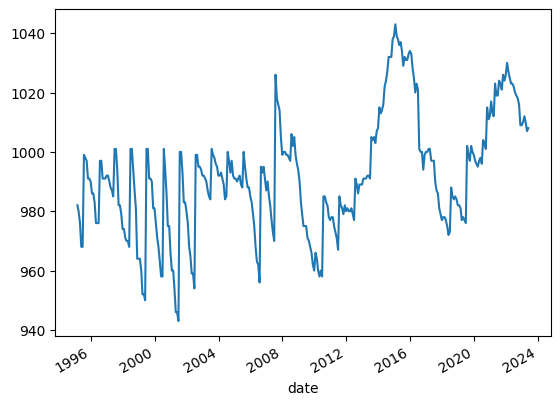

In [9]:
# quick check if we have approx 1000 constituents over time
(df_constituents.group_by(["date"]).agg(pl.col("asset_id")
               .count().alias("nr_assets"))
               .sort("date")
               .to_pandas()
               .set_index("date")["nr_assets"].plot()
);